# 🧪 Практическая работа: Методы классификации (Food-101 mini)

В этой работе мы возьмём мини-датасет **Food-101** (15 классов)  
и последовательно применим к нему несколько классических методов классификации.

---

## 🔹 Данные
- Используем уменьшенный набор данных Food-101 с 15 классами.
- Препроцессинг изображений фиксирован для всей работы.

---

## 🔹 Цель
Сравнить работу разных алгоритмов классификации по метрикам качества  
и матрицам ошибок.

In [1]:
# ============================================================
# Подготовка окружения: импорты, устройство, воспроизводимость
# ============================================================

# --- стандартные библиотеки ---
import os, random
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- PyTorch ---
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# --- Hugging Face Datasets ---
from datasets import load_dataset

# --- TorchVision ---
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode

# -----------------------------
# Функция для воспроизводимости
# -----------------------------
def set_seed(seed: int = 42) -> None:
    """Фиксирует все ГСЧ для повторяемых результатов."""
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(111)

# -----------------------------
# Определение устройства (CPU/GPU)
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

if torch.cuda.is_available():
    # Детерминизм на CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


Device: cuda


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 75750
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 25250
    })
})
Классов: 101
Первые 10 классов: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']
Train size: 75,750 | Test size: 25,250


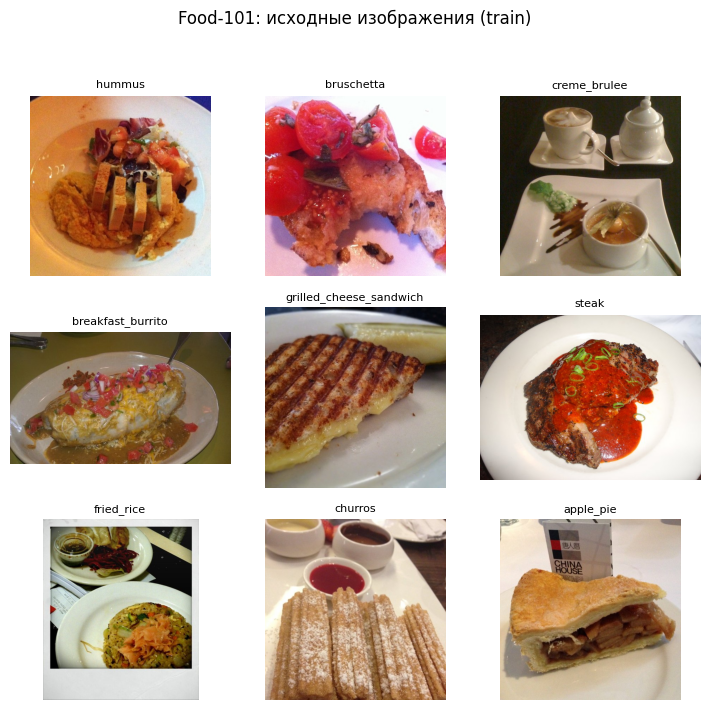

In [2]:
# ============================================================
# Загрузка датасета Food-101 и первичный осмотр данных
# ============================================================

from collections import Counter

DATA_CACHE_DIR = "./data_cache"  # путь для кеширования датасета
ds = load_dataset("food101", cache_dir=DATA_CACHE_DIR)
print(ds)  # вывод доступных сплитов

# HF: 'validation' = официальный тест Food-101
train_hf = ds["train"]
test_hf  = ds["validation"]

# Список классов
class_names = train_hf.features["label"].names
num_classes = len(class_names)
print(f"Классов: {num_classes}")
print("Первые 10 классов:", class_names[:10])

# Размера выборок
print(f"Train size: {len(train_hf):,} | Test size: {len(test_hf):,}")

# -----------------------------
# Функция для отображения изображений
# -----------------------------
def show_images(split, idxs=None, rows=3, cols=3, seed=42, title="Примеры изображений"):
    """
    Показывает изображения из датасета HF.
    Использует фиксированный seed для воспроизводимости.
    """
    set_seed(seed)
    n = rows * cols

    if idxs is None:
        idxs = random.sample(range(len(split)), k=min(n, len(split)))
    else:
        idxs = idxs[:n]

    fig, axs = plt.subplots(rows, cols, figsize=(cols * 2.4, rows * 2.4))
    fig.suptitle(title, fontsize=12)

    for ax, i in zip(axs.ravel(), idxs):
        ex = split[int(i)]
        img = ex["image"]
        label = class_names[int(ex["label"])]

        ax.imshow(img)
        ax.set_title(label, fontsize=8)
        ax.axis("off")

    # Остальные пустые ячейки выключаем
    for ax in axs.ravel()[len(idxs):]:
        ax.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Показ первых изображений
show_images(train_hf, title="Food-101: исходные изображения (train)")


In [3]:
# ============================================================
# Формируем MINI-датасет на 15 классов (train/val/test по классам)
# ============================================================

set_seed(111)  # воспроизводимость

from collections import defaultdict, Counter
from datasets import DatasetDict

# Конфигурация мини-набора
K_CLASSES        = 15         
TRAIN_PER_CLASS  = 600
VAL_PER_CLASS    = 150
TEST_PER_CLASS   = 250

# 1) выбираем K случайных классов
all_cls_ids = np.arange(len(class_names))
random.shuffle(all_cls_ids)
chosen_cls = np.sort(all_cls_ids[:K_CLASSES])
chosen_names = [class_names[i] for i in chosen_cls]

print(f"Выбрали {K_CLASSES} классов:")
print(chosen_names)

# 2) собираем индексы по классам
by_lbl_train = defaultdict(list)
for i, y in enumerate(train_hf["label"]):
    if y in chosen_cls:
        by_lbl_train[int(y)].append(i)

by_lbl_test = defaultdict(list)
for i, y in enumerate(test_hf["label"]):
    if y in chosen_cls:
        by_lbl_test[int(y)].append(i)

# 3) формируем индексы train/val/test
train_idx_total, val_idx_total, test_idx_total = [], [], []

for c in chosen_cls:
    # --- train/val ---
    tr_ids = by_lbl_train[int(c)]
    random.shuffle(tr_ids)

    need_val   = min(VAL_PER_CLASS, len(tr_ids))
    need_train = min(TRAIN_PER_CLASS, max(0, len(tr_ids) - need_val))

    val_idx_c   = tr_ids[:need_val]
    train_idx_c = tr_ids[need_val:need_val + need_train]

    # --- test ---
    te_ids = by_lbl_test[int(c)]
    random.shuffle(te_ids)
    test_idx_c = te_ids[:min(TEST_PER_CLASS, len(te_ids))]

    val_idx_total.extend(val_idx_c)
    train_idx_total.extend(train_idx_c)
    test_idx_total.extend(test_idx_c)

# 4) собираем HF-сплиты
train_small = train_hf.select(train_idx_total)
val_small   = train_hf.select(val_idx_total)
test_small  = test_hf.select(test_idx_total)

food101_small = DatasetDict({
    "train": train_small,
    "val":   val_small,
    "test":  test_small,
})

food101_small


Выбрали 15 классов:
['baklava', 'beef_carpaccio', 'beet_salad', 'bibimbap', 'caesar_salad', 'carrot_cake', 'chicken_wings', 'club_sandwich', 'edamame', 'fish_and_chips', 'gnocchi', 'pad_thai', 'pork_chop', 'ramen', 'tacos']


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 9000
    })
    val: Dataset({
        features: ['image', 'label'],
        num_rows: 2250
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 3750
    })
})

TRAIN (MINI-15) (N=9000)


,class_id,class,count
0,2,baklava,600
1,3,beef_carpaccio,600
2,5,beet_salad,600
3,7,bibimbap,600
4,11,caesar_salad,600
5,14,carrot_cake,600
6,20,chicken_wings,600
7,25,club_sandwich,600
8,33,edamame,600
9,38,fish_and_chips,600


VAL   (MINI-15) (N=2250)


,class_id,class,count
0,2,baklava,150
1,3,beef_carpaccio,150
2,5,beet_salad,150
3,7,bibimbap,150
4,11,caesar_salad,150
5,14,carrot_cake,150
6,20,chicken_wings,150
7,25,club_sandwich,150
8,33,edamame,150
9,38,fish_and_chips,150


TEST  (MINI-15) (N=3750)


,class_id,class,count
0,2,baklava,250
1,3,beef_carpaccio,250
2,5,beet_salad,250
3,7,bibimbap,250
4,11,caesar_salad,250
5,14,carrot_cake,250
6,20,chicken_wings,250
7,25,club_sandwich,250
8,33,edamame,250
9,38,fish_and_chips,250


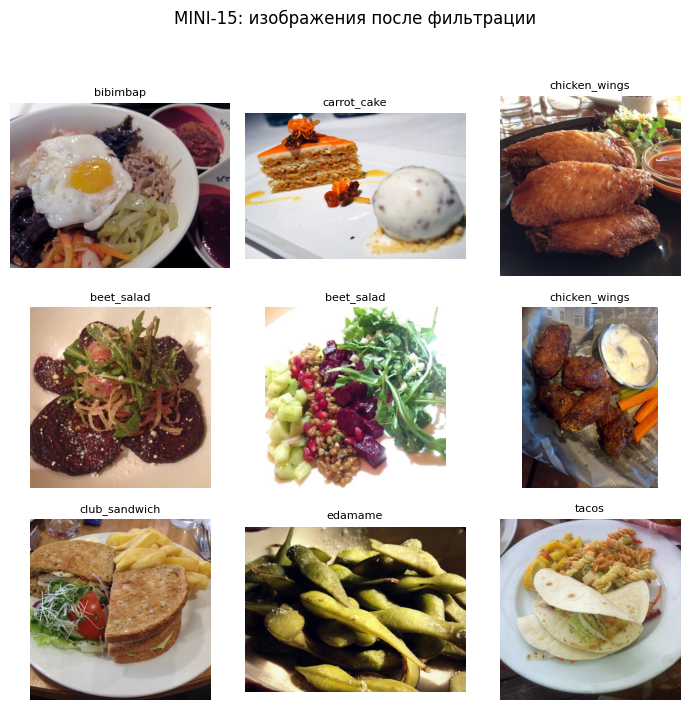

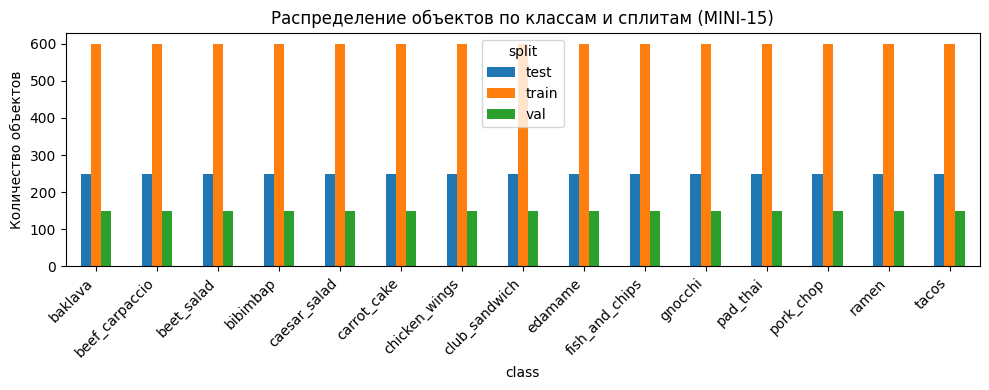

In [4]:
# ============================================================
# Баланс классов и визуальная проверка MINI-15
# ============================================================

def balance_table(split, title):
    """Строит таблицу с числом объектов по классам."""
    cnt = Counter(split["label"])
    df = pd.DataFrame({
        "class_id": chosen_cls,
        "class": [class_names[i] for i in chosen_cls],
        "count": [cnt.get(int(c), 0) for c in chosen_cls],
    }).sort_values("class").reset_index(drop=True)
    print(f"{title} (N={len(split)})")
    display(df)
    return df

bt_train = balance_table(food101_small["train"], "TRAIN (MINI-15)")
bt_val   = balance_table(food101_small["val"],   "VAL   (MINI-15)")
bt_test  = balance_table(food101_small["test"],  "TEST  (MINI-15)")

# --- визуальная проверка изображений ---
SAMPLE_IDX = random.sample(range(len(food101_small["train"])), 9)
show_images(food101_small["train"], SAMPLE_IDX, title="MINI-15: изображения после фильтрации")

# --- барплот распределения классов по сплитам ---
all_bt = pd.concat([
    bt_train.assign(split="train"),
    bt_val.assign(split="val"),
    bt_test.assign(split="test"),
], ignore_index=True)

pivot_counts = all_bt.pivot(index="class", columns="split", values="count")
pivot_counts.plot(kind="bar", figsize=(10, 4))
plt.title("Распределение объектов по классам и сплитам (MINI-15)")
plt.ylabel("Количество объектов")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [5]:
# =============== Ремаппер меток под MINI-15 ===============
set_seed(111)

# строим отображение: старый id -> новый [0..NUM_CLASSES-1]
LABEL2NEW = {int(old): new for new, old in enumerate(chosen_cls)}
NEW2LABEL = {new: int(old) for old, new in LABEL2NEW.items()}

NUM_CLASSES = len(chosen_cls)
print(f"NUM_CLASSES = {NUM_CLASSES}")
print("Пример маппинга (old -> new, class):")
for old, new in list(LABEL2NEW.items())[:5]:
    print(f"{old:3d} -> {new:2d} ({class_names[old]})")


NUM_CLASSES = 15
Пример маппинга (old -> new, class):
  2 ->  0 (baklava)
  3 ->  1 (beef_carpaccio)
  5 ->  2 (beet_salad)
  7 ->  3 (bibimbap)
 11 ->  4 (caesar_salad)


✅ DataLoader'ы готовы: train=9000, val=2250, test=3750, batch=64
Формы батча: torch.Size([64, 3, 224, 224]) torch.Size([64])


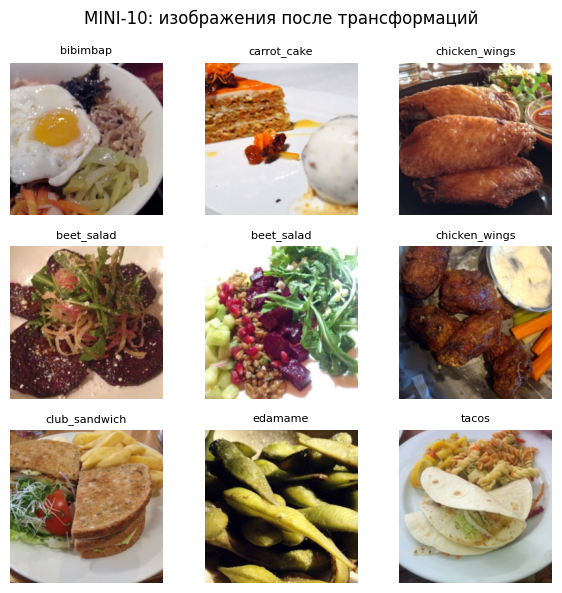

In [6]:
# =============== Трансформации (без аугм) + DataLoader’ы ===============
set_seed(111)

# --- базовые параметры трансформаций ---
IMG_SIZE = 224
MEAN = (0.485, 0.456, 0.406)
STD  = (0.229, 0.224, 0.225)

# --- трансформации (бейзлайн, без аугментаций) ---
baseline_tf = T.Compose([
    T.Resize(256, interpolation=InterpolationMode.BILINEAR),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(MEAN, STD),
])

# --- обёртка под HF split ---
class HFDataset(torch.utils.data.Dataset):
    def __init__(self, hf_split, transform, label_map):
        self.data = hf_split
        self.tf = transform
        self.label_map = label_map

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        ex = self.data[int(idx)]
        x = self.tf(ex["image"])
        y_old = int(ex["label"])
        y = self.label_map[y_old]  # ремап в [0..NUM_CLASSES-1]
        return x, y

train_ds = HFDataset(food101_small["train"], baseline_tf, LABEL2NEW)
val_ds   = HFDataset(food101_small["val"],   baseline_tf, LABEL2NEW)
test_ds  = HFDataset(food101_small["test"],  baseline_tf, LABEL2NEW)

# --- DataLoader'ы ---
BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"✅ DataLoader'ы готовы: train={len(train_ds)}, val={len(val_ds)}, test={len(test_ds)}, batch={BATCH_SIZE}")

# --- проверка одного батча ---
xb, yb = next(iter(train_loader))
print('Формы батча:', xb.shape, yb.shape)

# --- визуализация тех же картинок из MINI-10 после трансформаций ---
mean = torch.tensor(MEAN)[:, None, None]
std  = torch.tensor(STD)[:, None, None]

fig, axs = plt.subplots(3, 3, figsize=(6, 6))
fig.suptitle("MINI-15: изображения после трансформаций", y=0.98, fontsize=12)

for ax, idx in zip(axs.ravel(), SAMPLE_IDX):
    ex = food101_small["train"][idx]
    img_after = baseline_tf(ex["image"])
    img_show = (img_after * std + mean).permute(1, 2, 0).numpy().clip(0, 1)
    ax.imshow(img_show)
    ax.set_title(class_names[int(ex["label"])], fontsize=8)
    ax.axis("off")

for ax in axs.ravel()[len(SAMPLE_IDX):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


In [7]:
# ============================================================
# ResNet-18 как feature extractor: извлекаем признаки для sklearn
# ============================================================

from torchvision import models

# Загружаем предобученную ResNet-18 и замораживаем веса
feat_net = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for p in feat_net.parameters():
    p.requires_grad = False

# Откусываем классификатор: получаем вектор признаков (512)
feat_net.fc = nn.Identity()
feat_net = feat_net.to(device).eval()

def extract_features(dataloader, model, device):
    """Прогоняет весь датасет через модель и возвращает X, y как numpy-массивы."""
    all_feats = []
    all_labels = []
    with torch.no_grad():
        for xb, yb in dataloader:
            xb = xb.to(device)
            z = model(xb)              # [B, 512]
            all_feats.append(z.cpu().numpy())
            all_labels.append(yb.numpy())
    X = np.concatenate(all_feats, axis=0)
    y = np.concatenate(all_labels, axis=0)
    return X, y

X_train, y_train = extract_features(train_loader, feat_net, device)
X_val,   y_val   = extract_features(val_loader,   feat_net, device)
X_test,  y_test  = extract_features(test_loader,  feat_net, device)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape,   y_val.shape)
print("Test: ", X_test.shape,  y_test.shape)


Train: (9000, 512) (9000,)
Val:   (2250, 512) (2250,)
Test:  (3750, 512) (3750,)


## 🧩 Извлечение признаков с помощью ResNet-18

Классические методы классификации (kNN, SVM, логрегрессия и др.) работают только с числовыми векторами фиксированной длины.  
Чтобы применять их к изображениям, нужно сначала преобразовать каждую картинку в **вектор признаков**.

Для этого мы используем **предобученную ResNet-18** как feature extractor:

- удаляем финальный классификатор,
- сеть переводит изображение → вектор длины **512**,
- веса ResNet не обучаются — она просто извлекает признаки.

Такой подход позволяет применять более простые классификаторы к изображениям без обучения нейросети.

После этого шага мы получим:
- `X_train`, `X_val`, `X_test` — векторы признаков,
- `y_train`, `y_val`, `y_test` — метки классов.

> Примечание: размер вектора (512) определяется архитектурой ResNet-18.  
> После последнего сверточного блока сеть формирует 512 каналов признаков  
> и сжимает их глобальным усреднением, получая итоговый embedding длины 512.



## 🧪 Бейзлайн: случайный классификатор

Перед тем как использовать осмысленные методы, зададим простой ориентир —  
классификатор, который **случайно угадывает класс**.

Так как наш датасет сбалансирован (каждый класс представлен примерно одинаково),  
более осмысленного «самого частого класса» тут нет — любой один класс был бы выбран произвольно.

Бейзлайн-стратегия:
- выбираем класс случайно и равновероятно среди всех 15 классов;
- независимо для каждого объекта.

Ожидаемая точность такого классификатора примерно равна:

$\text{Accuracy} \approx \frac{1}{\text{NUM\_CLASSES}}$.

то есть около 0.067 для 15 классов.


Число классов: 15
Классы: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
TRAIN: accuracy=0.066, macro-F1=0.066
VAL  : accuracy=0.067, macro-F1=0.067
TEST : accuracy=0.063, macro-F1=0.063


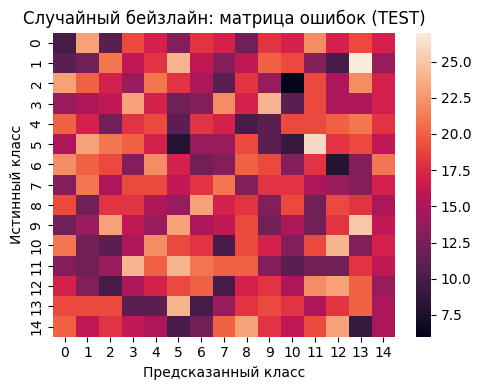

In [8]:
# ============================================================
# Бейзлайн: случайный классификатор (равномерное угадывание класса)
# ============================================================

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns

set_seed(111)  # фиксируем сид для воспроизводимого "случайного" угадывания

classes = np.unique(y_train)
NUM_CLASSES = len(classes)
print(f"Число классов: {NUM_CLASSES}")
print("Классы:", classes)

def random_baseline_predict(y_true, classes):
    """Генерирует случайные предсказания с равномерным распределением по классам."""
    return np.random.choice(classes, size=len(y_true), replace=True)

def print_metrics(split_name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    print(f"{split_name}: accuracy={acc:.3f}, macro-F1={f1m:.3f}")

# Генерируем предсказания для каждого сплита
y_pred_train = random_baseline_predict(y_train, classes)
y_pred_val   = random_baseline_predict(y_val,   classes)
y_pred_test  = random_baseline_predict(y_test,  classes)

print_metrics("TRAIN", y_train, y_pred_train)
print_metrics("VAL  ", y_val,   y_pred_val)
print_metrics("TEST ", y_test,  y_pred_test)

# Матрица ошибок для теста
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=False, fmt="d", cbar=True)
plt.title("Случайный бейзлайн: матрица ошибок (TEST)")
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.tight_layout()
plt.show()


In [9]:
# ============================================================
# Глобальный словарь для хранения результатов всех моделей
# ============================================================

results = {}

def log_results(model_name, split, y_true, y_pred):
    """Сохраняет accuracy и macro-F1 для указанного метода и сплита."""
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")

    if model_name not in results:
        results[model_name] = {}

    results[model_name][split] = {
        
        "accuracy": acc,
        "macro_f1": f1m,
    }


---

## 🔹 Метод 1: k-ближайших соседей (kNN)

Первый осмысленный классификатор — k-ближайших соседей.

Идея метода:
- для каждого объекта находим его k ближайших соседей в пространстве признаков;
- класс выбираем по большинству среди этих соседей.

TRAIN: accuracy=0.806, macro-F1=0.805
VAL  : accuracy=0.714, macro-F1=0.713
TEST : accuracy=0.773, macro-F1=0.770


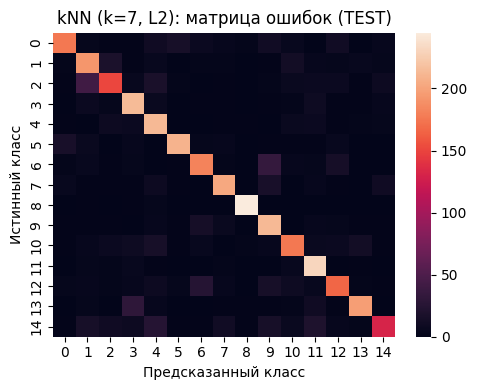

In [10]:
# ============================================================
# Метод 1: k-ближайших соседей (kNN)
# ============================================================

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns

set_seed(111)

# --- обучаем ---
knn = KNeighborsClassifier(
    n_neighbors=7,
    metric="cosine",
    n_jobs=-1
)

knn.fit(X_train, y_train)

# --- предсказания ---
y_pred_train = knn.predict(X_train)
y_pred_val   = knn.predict(X_val)
y_pred_test  = knn.predict(X_test)

# --- логируем метрики ---
log_results("kNN (k=7, L2)", "train", y_train, y_pred_train)
log_results("kNN (k=7, L2)", "val",   y_val,   y_pred_val)
log_results("kNN (k=7, L2)", "test",  y_test,  y_pred_test)

# --- вывод на экран ---
print_metrics("TRAIN", y_train, y_pred_train)
print_metrics("VAL  ", y_val,   y_pred_val)
print_metrics("TEST ", y_test,  y_pred_test)

# --- матрица ошибок ---
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=False, fmt="d", cbar=True)
plt.title("kNN (k=7, L2): матрица ошибок (TEST)")
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.tight_layout()
plt.show()


## 🔍 Визуализация признаков ResNet-18 с помощью t-SNE

Посмотрим как выглядят наши объекты в пространстве признаков ResNet-18.

Для этого используем метод **t-SNE** (t-Distributed Stochastic Neighbor Embedding):

- на вход подаём векторы признаков размерности 512;
- t-SNE отображает их в 2D так, чтобы похожие объекты оказались ближе друг к другу;
- точки раскрашиваем по классам.

Так можно визуально оценить:
- образуют ли классы отдельные кластеры;
- какие классы пересекаются;
- также почему метод kNN показал неплохие результаты.


Запускаем t-SNE на 2000 объектах...


C:\Users\Alexandr\AppData\Local\Temp\ipykernel_14064\3017369406.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", num_classes)


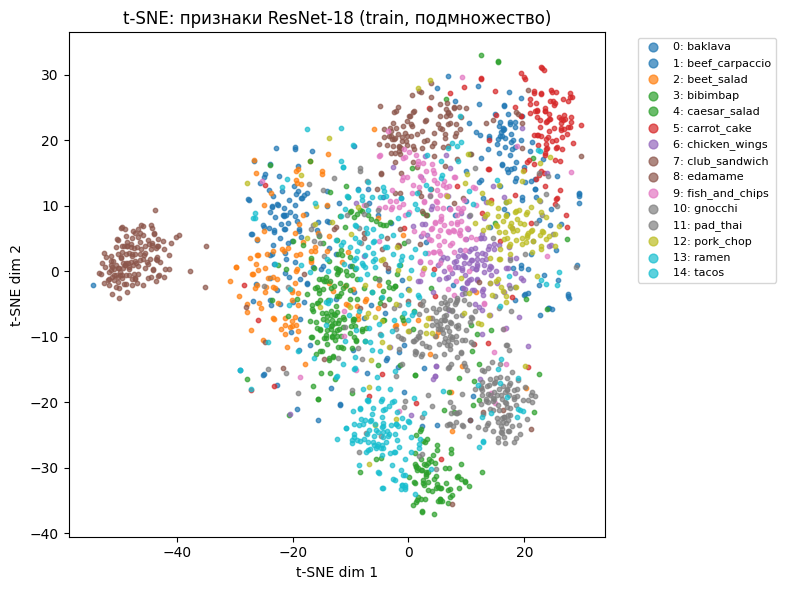

In [11]:
# ============================================================
# t-SNE визуализация признаков ResNet-18 (2D)
# ============================================================

from sklearn.manifold import TSNE

set_seed(111)

# Чтобы t-SNE не был слишком медленным, возьмём подмножество train
MAX_POINTS = 2000

n_samples = min(len(X_train), MAX_POINTS)
idxs = np.random.choice(len(X_train), size=n_samples, replace=False)

X_sample = X_train[idxs]
y_sample = y_train[idxs]

print(f"Запускаем t-SNE на {n_samples} объектах...")

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="random",
    random_state=111,
)
X_2d = tsne.fit_transform(X_sample)

# Рисуем точки, раскрашенные по классам
plt.figure(figsize=(8, 6))

num_classes = len(np.unique(y_sample))
cmap = plt.cm.get_cmap("tab10", num_classes)

for cls in range(num_classes):
    mask = (y_sample == cls)
    plt.scatter(
        X_2d[mask, 0],
        X_2d[mask, 1],
        s=10,
        alpha=0.7,
        color=cmap(cls),
        label=f"{cls}: {class_names[NEW2LABEL[cls]]}" if 'NEW2LABEL' in globals() else f"class {cls}"
    )

plt.title("t-SNE: признаки ResNet-18 (train, подмножество)")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.legend(markerscale=2, fontsize=8, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


### 🧩 Интерпретация t-SNE

Визуализация показывает, что признаки ResNet-18 образуют чётко различимые кластеры:

- некоторые классы отделяются очень хорошо  
- другие классы частично пересекаются  
- внутри каждого класса видны плотные «облака» — это означает, что ResNet
  извлекает устойчивые признаки даже из разных изображений одного блюда.

Таким образом, наше пространство из 512 признаков уже обладает хорошей
структурой, и поэтому даже простые алгоритмы — такие как kNN — могут показывать
довольно неплохую точность.


---
## 🔹 Метод 2: Логистическая регрессия

Это линейный классификатор: он пытается найти такие веса признаков,
чтобы максимизировать правдоподобие правильных классов.

c:\Prgrm\Intro_in_ML\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


TRAIN: accuracy=0.954, macro-F1=0.954
VAL  : accuracy=0.759, macro-F1=0.759
TEST : accuracy=0.821, macro-F1=0.820


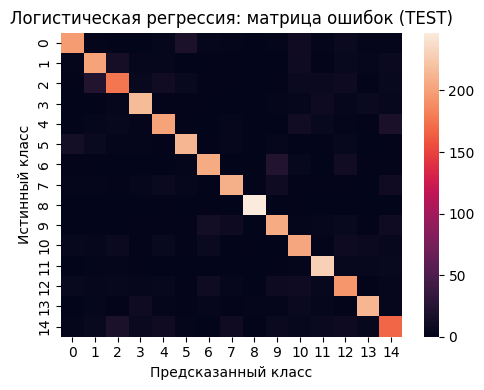

In [12]:
# ============================================================
# Метод 2: Логистическая регрессия
# ============================================================

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns

set_seed(111)

# Пайплайн: стандартизация признаков + логистическая регрессия
logreg_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        C=0.1,  # Регуляризация: меньше C → меньше переобучение
        max_iter=1000,
        multi_class="multinomial",
        solver="lbfgs",
        n_jobs=-1,
        random_state=111,
    )),
])

# --- обучение ---
logreg_clf.fit(X_train, y_train)

# --- предсказания ---
y_pred_train = logreg_clf.predict(X_train)
y_pred_val   = logreg_clf.predict(X_val)
y_pred_test  = logreg_clf.predict(X_test)

# --- логируем метрики ---
log_results("Logistic Regression (C=0.1)", "train", y_train, y_pred_train)
log_results("Logistic Regression (C=0.1)", "val",   y_val,   y_pred_val)
log_results("Logistic Regression (C=0.1)", "test",  y_test,  y_pred_test)

# --- вывод ---
print_metrics("TRAIN", y_train, y_pred_train)
print_metrics("VAL  ", y_val,   y_pred_val)
print_metrics("TEST ", y_test,  y_pred_test)

# --- матрица ошибок ---
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=False, fmt="d", cbar=True)
plt.title("Логистическая регрессия: матрица ошибок (TEST)")
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.tight_layout()
plt.show()


---
## 🔹 Метод 3: Линейный SVM (Support Vector Machine)

Линейный SVM ищет разделяющую гиперплоскость, которая максимально увеличивает зазор
(margin) между классами.

TRAIN: accuracy=0.954, macro-F1=0.953
VAL  : accuracy=0.709, macro-F1=0.708
TEST : accuracy=0.758, macro-F1=0.757


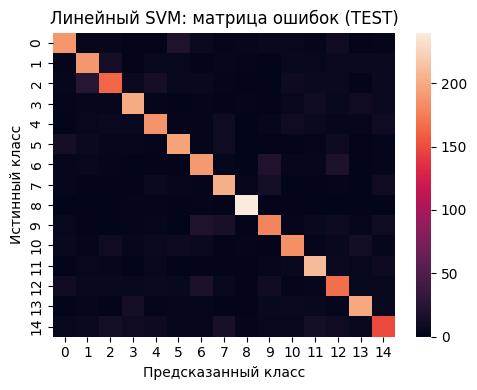

In [13]:
# ============================================================
# Метод 3: Линейный SVM (LinearSVC)
# ============================================================

from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns

set_seed(111)

# --- модель + стандартизация ---
svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", LinearSVC(
        C=1.0,
        class_weight=None,
        random_state=111,
    )),
])

# --- обучение ---
svm_clf.fit(X_train, y_train)

# --- предсказания ---
y_pred_train = svm_clf.predict(X_train)
y_pred_val   = svm_clf.predict(X_val)
y_pred_test  = svm_clf.predict(X_test)

# --- логируем метрики ---
log_results("Linear SVM (C=1.0)", "train", y_train, y_pred_train)
log_results("Linear SVM (C=1.0)", "val",   y_val,   y_pred_val)
log_results("Linear SVM (C=1.0)", "test",  y_test,  y_pred_test)

# --- вывод ---
print_metrics("TRAIN", y_train, y_pred_train)
print_metrics("VAL  ", y_val,   y_pred_val)
print_metrics("TEST ", y_test,  y_pred_test)

# --- матрица ошибок ---
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=False, fmt="d", cbar=True)
plt.title("Линейный SVM: матрица ошибок (TEST)")
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.tight_layout()
plt.show()


TRAIN: accuracy=0.729, macro-F1=0.730
VAL  : accuracy=0.688, macro-F1=0.688
TEST : accuracy=0.757, macro-F1=0.757


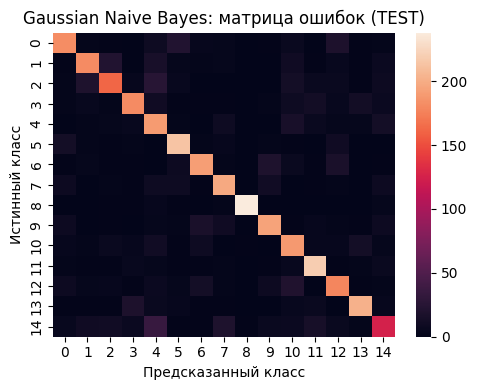

In [14]:
# ============================================================
# Метод 4: Наивный Байес (GaussianNB)
# ============================================================

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns

set_seed(111)

nb_clf = GaussianNB()

# --- обучение ---
nb_clf.fit(X_train, y_train)

# --- предсказания ---
y_pred_train = nb_clf.predict(X_train)
y_pred_val   = nb_clf.predict(X_val)
y_pred_test  = nb_clf.predict(X_test)

# --- логируем метрики ---
log_results("Gaussian Naive Bayes", "train", y_train, y_pred_train)
log_results("Gaussian Naive Bayes", "val",   y_val,   y_pred_val)
log_results("Gaussian Naive Bayes", "test",  y_test,  y_pred_test)

# --- вывод ---
print_metrics("TRAIN", y_train, y_pred_train)
print_metrics("VAL  ", y_val,   y_pred_val)
print_metrics("TEST ", y_test,  y_pred_test)

# --- матрица ошибок ---
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=False, fmt="d", cbar=True)
plt.title("Gaussian Naive Bayes: матрица ошибок (TEST)")
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.tight_layout()
plt.show()


TRAIN: accuracy=1.000, macro-F1=1.000
VAL  : accuracy=0.415, macro-F1=0.416
TEST : accuracy=0.434, macro-F1=0.434


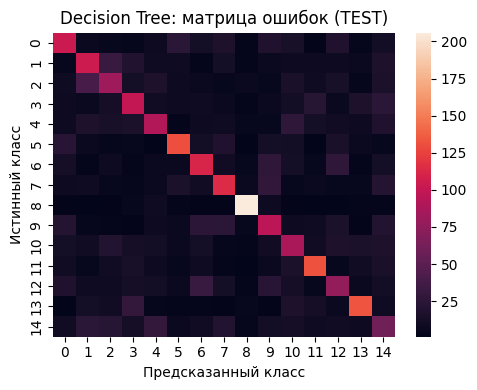

In [15]:
# ============================================================
# Метод 5: Дерево решений
# ============================================================

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns

set_seed(111)

tree_clf = DecisionTreeClassifier(
    max_depth=None,        # можно потом ограничить, чтобы уменьшить переобучение
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=111,
)

# --- обучение ---
tree_clf.fit(X_train, y_train)

# --- предсказания ---
y_pred_train = tree_clf.predict(X_train)
y_pred_val   = tree_clf.predict(X_val)
y_pred_test  = tree_clf.predict(X_test)

# --- логируем метрики ---
log_results("Decision Tree", "train", y_train, y_pred_train)
log_results("Decision Tree", "val",   y_val,   y_pred_val)
log_results("Decision Tree", "test",  y_test,  y_pred_test)

# --- вывод ---
print_metrics("TRAIN", y_train, y_pred_train)
print_metrics("VAL  ", y_val,   y_pred_val)
print_metrics("TEST ", y_test,  y_pred_test)

# --- матрица ошибок ---
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=False, fmt="d", cbar=True)
plt.title("Decision Tree: матрица ошибок (TEST)")
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.tight_layout()
plt.show()


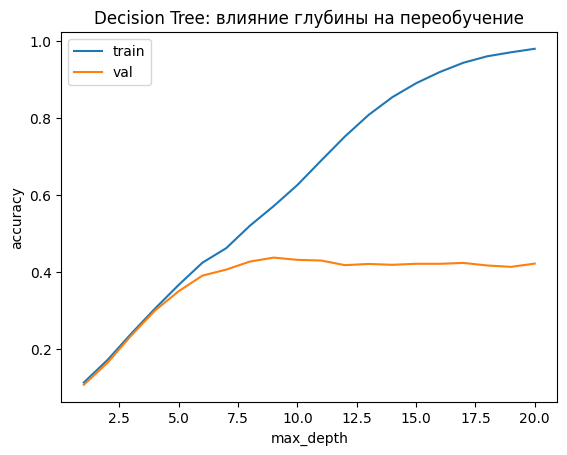

In [16]:
depths = list(range(1, 21))
train_acc = []
val_acc = []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=111)
    clf.fit(X_train, y_train)
    train_acc.append(clf.score(X_train, y_train))
    val_acc.append(clf.score(X_val, y_val))

plt.plot(depths, train_acc, label="train")
plt.plot(depths, val_acc, label="val")
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.legend()
plt.title("Decision Tree: влияние глубины на переобучение")
plt.show()


**Вывод.** Дерево решений на ResNet-признаках показывает выраженное переобучение:  
при увеличении глубины train-accuracy стремится к 1.0, тогда как качество на валидации начинает снижаться уже после глубины ~7–8. Это связано с тем, что дерево использует жёсткие пороги и пытается “запомнить” сложную структуру 512-мерных embeddings вместо того, чтобы ее обобщать. Поэтому Decision Tree служит хорошей иллюстрацией того, как классические модели легко переобучаются на высокоуровневых признаках и требуют оптимизации.


TRAIN: accuracy=1.000, macro-F1=1.000
VAL  : accuracy=0.732, macro-F1=0.731
TEST : accuracy=0.785, macro-F1=0.783


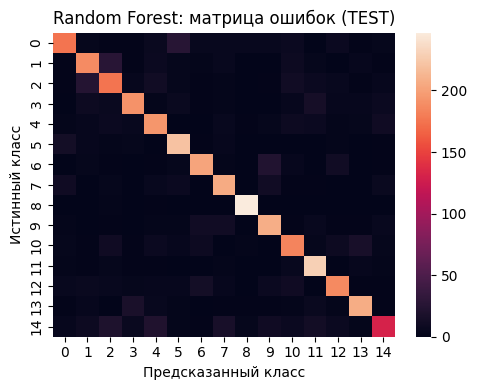

In [17]:
# ============================================================
# Метод 5: Random Forest
# ============================================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns

set_seed(111)

# --- модель ---
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=111,
)

# --- обучение ---
rf_clf.fit(X_train, y_train)

# --- предсказания ---
y_pred_train = rf_clf.predict(X_train)
y_pred_val   = rf_clf.predict(X_val)
y_pred_test  = rf_clf.predict(X_test)

# --- логирование метрик ---
log_results("Random Forest", "train", y_train, y_pred_train)
log_results("Random Forest", "val",   y_val,   y_pred_val)
log_results("Random Forest", "test",  y_test,  y_pred_test)

# --- вывод ---
print_metrics("TRAIN", y_train, y_pred_train)
print_metrics("VAL  ", y_val,   y_pred_val)
print_metrics("TEST ", y_test,  y_pred_test)

# --- матрица ошибок ---
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=False, fmt="d", cbar=True)
plt.title("Random Forest: матрица ошибок (TEST)")
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.tight_layout()
plt.show()


## 🔹 Метод 6: Нелинейный SVM с RBF-ядром

Линейный SVM ищет одну гиперплоскость в исходном пространстве признаков.  
Нелинейный SVM с RBF-ядром фактически переходит в другое, более высокоразмерное
пространство и может строить *изогнутые* границы между классами.

На embedding-признаках ResNet-18 такой SVM может лучше подстраиваться под
сложную структуру классов, чем линейные методы, но при этом работать медленнее.


TRAIN: accuracy=0.961, macro-F1=0.961
VAL  : accuracy=0.787, macro-F1=0.788
TEST : accuracy=0.854, macro-F1=0.854


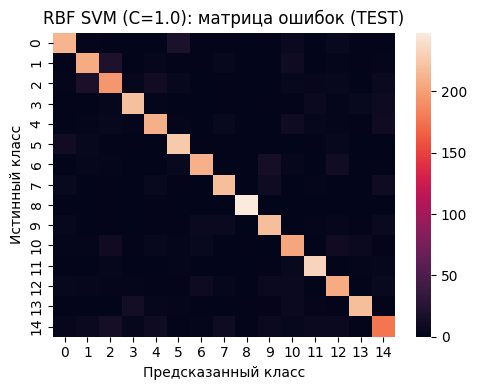

In [18]:
# ============================================================
# Нелинейный SVM с RBF-ядром (SVC)
# ============================================================

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns

set_seed(111)

rbf_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(
        kernel="rbf",
        C=1.0,           # можно поиграть: 0.5, 1.0, 2.0
        gamma="scale",   # автоматический выбор гаммы
        decision_function_shape="ovo",
        random_state=111,
    )),
])

# --- обучение (может занять больше времени, чем LinearSVC) ---
rbf_svm_clf.fit(X_train, y_train)

# --- предсказания ---
y_pred_train = rbf_svm_clf.predict(X_train)
y_pred_val   = rbf_svm_clf.predict(X_val)
y_pred_test  = rbf_svm_clf.predict(X_test)

# --- логируем метрики ---
log_results("RBF SVM (C=1.0)", "train", y_train, y_pred_train)
log_results("RBF SVM (C=1.0)", "val",   y_val,   y_pred_val)
log_results("RBF SVM (C=1.0)", "test",  y_test,  y_pred_test)

# --- вывод ---
print_metrics("TRAIN", y_train, y_pred_train)
print_metrics("VAL  ", y_val,   y_pred_val)
print_metrics("TEST ", y_test,  y_pred_test)

# --- матрица ошибок ---
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=False, fmt="d", cbar=True)
plt.title("RBF SVM (C=1.0): матрица ошибок (TEST)")
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.tight_layout()
plt.show()


## 🔹 Метод 7: Нейронная сеть (MLP-классификатор)

MLP — это многослойный перцептрон, последовательность полносвязных слоёв.
Он работает как нелинейный классификатор: благодаря скрытым слоям и функциям активации
(ReLU) модель способна строить сложные разделяющие границы между классами.

На эмбеддингах ResNet-18 MLP часто работает лучше линейных моделей, потому что 
он дополнительно "достраивает" поверх извлечённых признаков гибкую нелинейную
классификационную функцию. Используем два скрытых слоя (256 → 128) и раннюю остановку,
чтобы избежать переобучения.


TRAIN: accuracy=1.000, macro-F1=1.000
VAL  : accuracy=0.779, macro-F1=0.778
TEST : accuracy=0.828, macro-F1=0.828


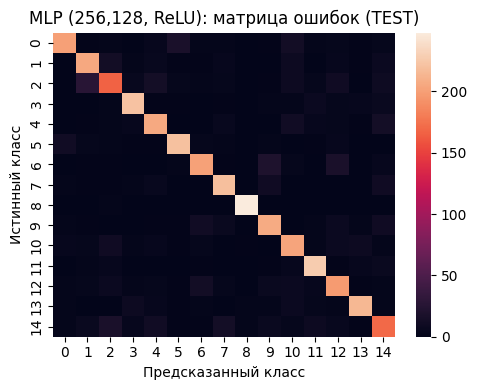

In [20]:
# ============================================================
# Метод 7: Нейросеть (MLP-классификатор на фичах ResNet-18)
# ============================================================

from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns

set_seed(111)

mlp_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(256, 128),
        activation="relu",
        alpha=1e-4,          # L2-регуляризация
        batch_size=64,
        learning_rate_init=1e-3,
        max_iter=50,         # можно увеличить до 100, если не сойдётся
        early_stopping=False, # встроенная валидация и ранняя остановка
        random_state=111,
        verbose=False,
    )),
])

# --- обучение ---
mlp_clf.fit(X_train, y_train)

# --- предсказания ---
y_pred_train = mlp_clf.predict(X_train)
y_pred_val   = mlp_clf.predict(X_val)
y_pred_test  = mlp_clf.predict(X_test)

# --- логируем метрики ---
log_results("MLP (256,128, ReLU)", "train", y_train, y_pred_train)
log_results("MLP (256,128, ReLU)", "val",   y_val,   y_pred_val)
log_results("MLP (256,128, ReLU)", "test",  y_test,  y_pred_test)

# --- вывод ---
print_metrics("TRAIN", y_train, y_pred_train)
print_metrics("VAL  ", y_val,   y_pred_val)
print_metrics("TEST ", y_test,  y_pred_test)

# --- матрица ошибок ---
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=False, fmt="d", cbar=True)
plt.title("MLP (256,128, ReLU): матрица ошибок (TEST)")
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.tight_layout()
plt.show()


In [21]:
results

{'kNN (k=7, L2)': {'train': {'accuracy': 0.8061111111111111,
   'macro_f1': 0.8054092990239469},
  'val': {'accuracy': 0.7137777777777777, 'macro_f1': 0.7130715048459016},
  'test': {'accuracy': 0.7725333333333333, 'macro_f1': 0.7703892415059783}},
 'Logistic Regression (C=0.1)': {'train': {'accuracy': 0.9537777777777777,
   'macro_f1': 0.9538027856139113},
  'val': {'accuracy': 0.7586666666666667, 'macro_f1': 0.7586380123775277},
  'test': {'accuracy': 0.8205333333333333, 'macro_f1': 0.8202275680448153}},
 'Linear SVM (C=1.0)': {'train': {'accuracy': 0.9535555555555556,
   'macro_f1': 0.9534348772331802},
  'val': {'accuracy': 0.7093333333333334, 'macro_f1': 0.7084608336388777},
  'test': {'accuracy': 0.7578666666666667, 'macro_f1': 0.7569443480621313}},
 'Gaussian Naive Bayes': {'train': {'accuracy': 0.7292222222222222,
   'macro_f1': 0.7298376202781774},
  'val': {'accuracy': 0.6875555555555556, 'macro_f1': 0.6883964966994007},
  'test': {'accuracy': 0.7573333333333333, 'macro_f1': 

In [22]:
# ============================================================
# Таблица итоговых метрик по всем моделям
# ============================================================

import pandas as pd

# Преобразуем results → список строк
rows = []
for model, scores in results.items():
    rows.append({
        "model": model,
        "train_acc": scores["train"]["accuracy"],
        "val_acc":   scores["val"]["accuracy"],
        "test_acc":  scores["test"]["accuracy"],
        "test_f1":   scores["test"]["macro_f1"],
        "overfit (train - val)": scores["train"]["accuracy"] - scores["val"]["accuracy"],
    })

df_results = pd.DataFrame(rows)

# сортировка по тестовой точности
df_results = df_results.sort_values("test_acc", ascending=False).reset_index(drop=True)

display(df_results.style.format({
    "train_acc": "{:.3f}",
    "val_acc": "{:.3f}",
    "test_acc": "{:.3f}",
    "test_f1": "{:.3f}",
    "overfit (train - val)": "{:.3f}",
}))


,model,train_acc,val_acc,test_acc,test_f1,overfit (train - val)
0,RBF SVM (C=1.0),0.961,0.787,0.854,0.854,0.174
1,"MLP (256,128, ReLU)",1.000,0.779,0.828,0.828,0.221
2,Logistic Regression (C=0.1),0.954,0.759,0.821,0.820,0.195
3,Random Forest,1.000,0.732,0.785,0.783,0.268
4,"kNN (k=7, L2)",0.806,0.714,0.773,0.770,0.092
5,Linear SVM (C=1.0),0.954,0.709,0.758,0.757,0.244
6,Gaussian Naive Bayes,0.729,0.688,0.757,0.757,0.042
7,Decision Tree,1.000,0.415,0.434,0.434,0.585


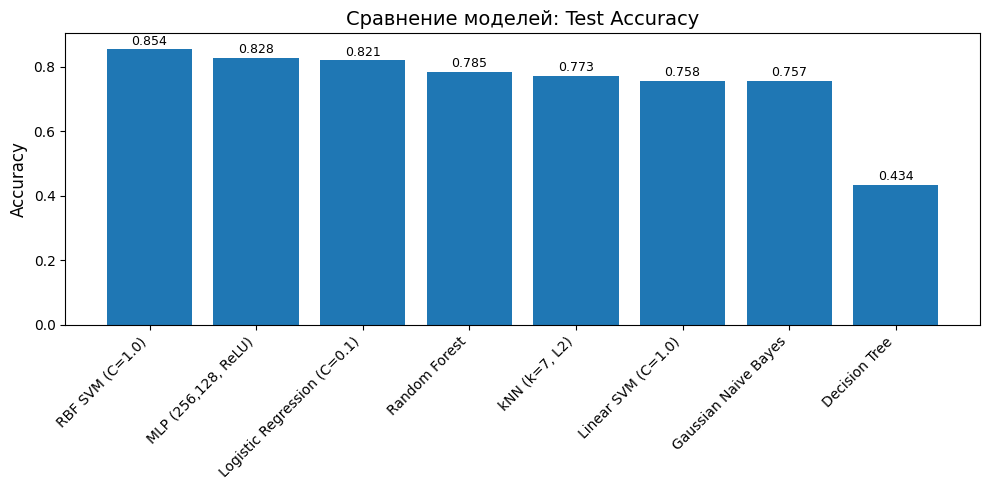

In [23]:
# ============================================================
# Barplot: Test Accuracy всех моделей
# ============================================================

import matplotlib.pyplot as plt
import numpy as np

# Берём отсортированный df_results (из предыдущей ячейки)
models = df_results["model"].values
test_acc = df_results["test_acc"].values

plt.figure(figsize=(10, 5))
bars = plt.bar(models, test_acc)

plt.title("Сравнение моделей: Test Accuracy", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(rotation=45, ha="right")

# подписи над столбцами
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.005,
        f"{height:.3f}",
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.ylim(0, test_acc.max() + 0.05)
plt.tight_layout()
plt.show()


## 🔍 Анализ переобучения моделей (Train → Val)

Чтобы оценить, насколько модель способна обобщать знания на новые данные,
полезно сравнивать её качество на обучении (train) и на валидации (val).

Разница `train_acc – val_acc` — простой и наглядный показатель степени
переобучения. Чем выше эта разница, тем хуже обобщающая способность модели.

График ниже помогает понять:
- какие модели стабильны и обобщают хорошо;
- какие склонны к переобучению (деревья, глубокие модели);
- какие модели слишком простые, но зато устойчивые (байес, kNN).


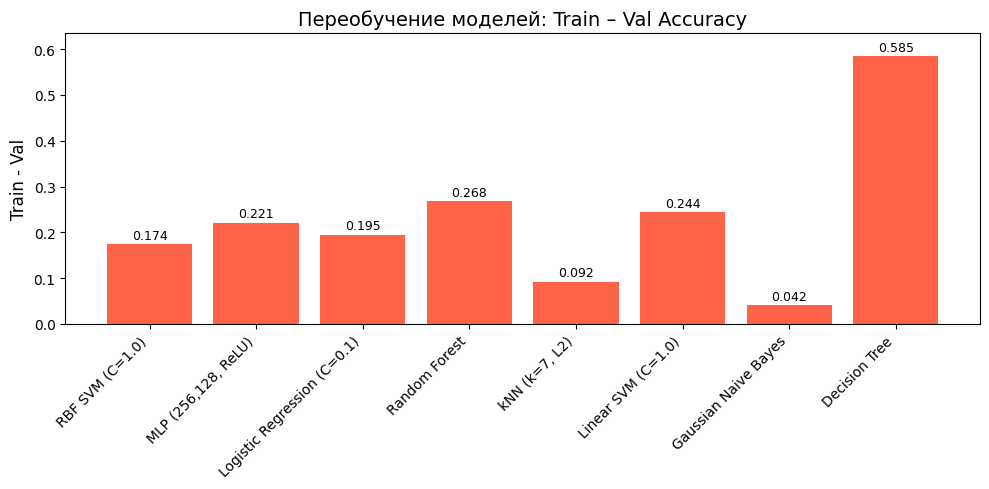

In [24]:
# ============================================================
# Overfitting plot: Train Accuracy – Val Accuracy
# ============================================================

import matplotlib.pyplot as plt
import numpy as np

models = df_results["model"].values
overfit = df_results["overfit (train - val)"].values

plt.figure(figsize=(10, 5))
bars = plt.bar(models, overfit, color="tomato")

plt.title("Переобучение моделей: Train – Val Accuracy", fontsize=14)
plt.ylabel("Train - Val", fontsize=12)
plt.xticks(rotation=45, ha="right")

# подписи над столбцами
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.005,
        f"{height:.3f}",
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.ylim(0, overfit.max() + 0.05)
plt.tight_layout()
plt.show()


## 📊 Итоги сравнения моделей

Мы обучили классические алгоритмы классификации на одинаковых фичах
(эмбеддинги ResNet-18). Это обеспечивает честное сравнение качества именно
классификаторов.

### Лучшие модели
1. **RBF-SVM (0.854)** — лучший результат: мощный нелинейный метод, хорошо работающий с плотными фичами.
2. **MLP (0.826)** — нейросеть на эмбеддингах показывает высокое качество и умеренное переобучение.
3. **Логистическая регрессия (0.820)** — простой, но удивительно сильный линейный метод.

### Средние результаты
- **Random Forest (0.785)** — сдерживает overfit, но уступает нелинейным методам.
- **Linear SVM / GaussianNB / kNN** — базовые модели, качество ограничено мощностью.

### Худший результат
- **Decision Tree (0.433)** — максимальное переобучение, плохая обобщающая способность.

### Общий вывод
На качественных эмбеддингах предобученной сети лучшие результаты показывают
нелинейные методы (RBF-SVM и MLP). Линейные модели (логрег, LinearSVM)
работают удивительно хорошо, что подтверждает высокую информативность
построенных признаков.


In [ ]:
# ============================================================
# Матрицы ошибок для трёх лучших моделей: RBF SVM, MLP, LogReg
# ============================================================

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_rbf = rbf_svm_clf.predict(X_test)
y_pred_mlp = mlp_clf.predict(X_test)
y_pred_log = logreg_clf.predict(X_test)

cm_rbf = confusion_matrix(y_test, y_pred_rbf)
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
cm_log = confusion_matrix(y_test, y_pred_log)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

cms = [
    (cm_log, "Logistic Regression"),
    (cm_mlp, "MLP (256,128, ReLU)"),
    (cm_rbf, "RBF SVM (C=1.0)"),
]

for ax, (cm, title) in zip(axes, cms):
    sns.heatmap(
        cm,
        ax=ax,
        annot=False,
        fmt="d",
        cbar=False
    )
    ax.set_title(title, fontsize=11)
    ax.set_xlabel("Предсказанный класс")
    ax.set_ylabel("Истинный класс")

plt.tight_layout()
plt.show()
